# Orientation of a non-linear molecule using strong THz fields

Simulate orientation of propylene oxide molecule produced by a strong THz filed of the kind reported in ["Optical generation of single-cycle 10 MW peak power 100 GHz waves", X. Wu, et al., Opt. Express 24, 21059 (2016)](https://doi.org/10.1364/OE.24.021059)

In [3]:
from field_free import field_free
from stark import dipole_me_matrix, field_free_matrix
from thz_field import thz_field
from tdse import propagate
from constants import DEBYE_TIMES_VOLTS_PER_CM_INTO_INVPS
import propylene_oxide

import numpy as np
from scipy.interpolate import RegularGridInterpolator
from scipy.spatial.transform import Rotation
import matplotlib.pyplot as plt

### Molecular data for propylene oxide molecule

In [4]:
rot_a = propylene_oxide.rot_a
rot_b = propylene_oxide.rot_b
rot_c = propylene_oxide.rot_c

# dipole moment in Debye
dipole_debye_abc = np.copy(propylene_oxide.dipole_expt_deb)

print(propylene_oxide.__doc__)
print("Rotational constants (MHz):", rot_a, rot_b, rot_c)
print("(a, b, c) principal-frame components of dipole moment (Debye):", dipole_debye_abc)

Molecular data for propylene oxide molecule

Rotational constants (in MHz):
    - spectroscopic measurements, see https://doi.org/10.1016/0022-2852(77)90268-5 and https://doi.org/10.1126/science.aae0328
Dipole moment:
    - calculated (in Debye), using CCSD(T)/aug-cc-pVTZ in the frozen-core approximation
    - measured (in Debye), see https://doi.org/10.1063/1.1743645

Rotational constants (MHz): 18023.89 6682.14 5951.39
(a, b, c) principal-frame components of dipole moment (Debye): [0.95 1.67 0.56]


### Field-free rotational energies and wavefunctions
The field-free rotational energies and wavefunctions are computed in the basis expansion of symmetric-top functions, i.e. as a linear combination of these functions. \
The two enantiomers of propylene oxide differ by the sign of the y-component of their dipole moment.

In [5]:
max_j = 6

rot_enr = {}
rot_vec = {}
rot_assignment = {}
rot_func_on_grid = {}

for j in range(max_j + 1):
    abc_axes, rot_enr[j], rot_vec[j], rot_assignment[j], grid, rot_func_on_grid[j] = (
        field_free(j, rot_a, rot_b, rot_c)
    )

print("(a, b, c) principal-frame axes correspond to molecular-frame axes:", abc_axes)
dipole_debye_xyz = [dipole_debye_abc['xyz'.index(cart)] for cart in abc_axes]
print("(x, y, z) molecular-frame components of dipole moment:", dipole_debye_xyz)

#Add dipole moment for other enantiomer
dipole_debye_xyz_ch = np.array([dipole_debye_xyz[0], -dipole_debye_xyz[1], dipole_debye_xyz[2]])
print("(x, y, z) molecular-frame components of dipole moment for other enantiomer:", dipole_debye_xyz_ch)

(a, b, c) principal-frame axes correspond to molecular-frame axes: ('z', 'y', 'x')
(x, y, z) molecular-frame components of dipole moment: [0.56, 1.67, 0.95]
(x, y, z) molecular-frame components of dipole moment for other enantiomer: [ 0.56 -1.67  0.95]


Print rotational energies and quantum number assignments

In [6]:
print("Rotational energies\n# (J, ka, kc)  E (MHz)")
for j in rot_enr.keys():
    for i, (e, (j, ka, kc)) in enumerate(zip(rot_enr[j], rot_assignment[j])):
        print(i, (j, ka, kc), e)

Rotational energies
# (J, ka, kc)  E (MHz)
0 (0, 0, 0) 0.0
0 (1, 0, 1) 12633.529999999999
1 (1, 1, 1) 23975.28
2 (1, 1, 0) 24706.03
0 (2, 0, 2) 37866.405302775536
1 (2, 1, 2) 48511.58999999999
2 (2, 1, 1) 50703.84
3 (2, 2, 1) 84729.08999999998
4 (2, 2, 0) 84763.27469722443
0 (3, 0, 3) 75630.75199711006
1 (3, 1, 3) 85295.16754314957
2 (3, 1, 0) 89678.66673962174
3 (3, 2, 2) 122629.68
4 (3, 2, 1) 122800.10800288993
5 (3, 3, 1) 181186.19245685043
6 (3, 3, 0) 181187.19326037826
0 (4, 0, 4) 125827.44703018782
1 (4, 1, 4) 134302.32304557206
2 (4, 1, 1) 141602.82597018147
3 (4, 2, 3) 173137.19753037777
4 (4, 2, 0) 173645.02619826462
5 (4, 3, 2) 231785.77695442789
6 (4, 3, 3) 231792.77402981845
7 (4, 4, 1) 313675.90246962226
8 (4, 4, 0) 313675.9267715476
0 (5, 0, 5) 188332.93397005636
1 (5, 1, 5) 195503.68732116293
2 (5, 1, 0) 206437.01544305246
3 (5, 2, 4) 236228.89590832658
4 (5, 2, 1) 237398.69339864876
5 (5, 3, 3) 295060.7582166728
6 (5, 3, 4) 295088.6795613417
7 (5, 4, 2) 376919.504091673

### Rotational matrix elements of dipole moment operator
The dipole matrix elements of the two enantiomers differ because of the different sign in the dipole moment, whereas the field-free Hamiltonian is the same for both.

In [7]:
# dipole matrix elelements
dipole_matrix = dipole_me_matrix(max_j, rot_vec, dipole_debye_xyz, linear=False)
#diople matrix elements for other enantiomer
dipole_matrix_ch = dipole_me_matrix(max_j, rot_vec, dipole_debye_xyz_ch, linear=False)

# field-free Hamiltonian - diagonal matrix with rotational energies
h0_matrix, assignment = field_free_matrix(max_j, rot_enr, rot_assignment)

Print assignments of rotational states, including the $m$-degeneracy

In [8]:
print("Rotational energies\n# (J, ka, kc, m)  E (MHz)")
for i, (j, ka, kc, m) in enumerate(assignment):
    print(i, (j, ka, kc, m), h0_matrix[i, i])

Rotational energies
# (J, ka, kc, m)  E (MHz)
0 (0, 0, 0, 0) 0.0
1 (1, 0, 1, -1) 12633.529999999999
2 (1, 0, 1, 0) 12633.529999999999
3 (1, 0, 1, 1) 12633.529999999999
4 (1, 1, 1, -1) 23975.28
5 (1, 1, 1, 0) 23975.28
6 (1, 1, 1, 1) 23975.28
7 (1, 1, 0, -1) 24706.03
8 (1, 1, 0, 0) 24706.03
9 (1, 1, 0, 1) 24706.03
10 (2, 0, 2, -2) 37866.405302775536
11 (2, 0, 2, -1) 37866.405302775536
12 (2, 0, 2, 0) 37866.405302775536
13 (2, 0, 2, 1) 37866.405302775536
14 (2, 0, 2, 2) 37866.405302775536
15 (2, 1, 2, -2) 48511.58999999999
16 (2, 1, 2, -1) 48511.58999999999
17 (2, 1, 2, 0) 48511.58999999999
18 (2, 1, 2, 1) 48511.58999999999
19 (2, 1, 2, 2) 48511.58999999999
20 (2, 1, 1, -2) 50703.84
21 (2, 1, 1, -1) 50703.84
22 (2, 1, 1, 0) 50703.84
23 (2, 1, 1, 1) 50703.84
24 (2, 1, 1, 2) 50703.84
25 (2, 2, 1, -2) 84729.08999999998
26 (2, 2, 1, -1) 84729.08999999998
27 (2, 2, 1, 0) 84729.08999999998
28 (2, 2, 1, 1) 84729.08999999998
29 (2, 2, 1, 2) 84729.08999999998
30 (2, 2, 0, -2) 84763.27469722443
31 

### Define THz field

Use field provided by `thz_field` module, which is a digitized version of the Figure 4 in ["Optical generation of single-cycle 10 MW peak power 100 GHz waves", X. Wu, et al., Opt. Express 24, 21059 (2016)](https://doi.org/10.1364/OE.24.021059)

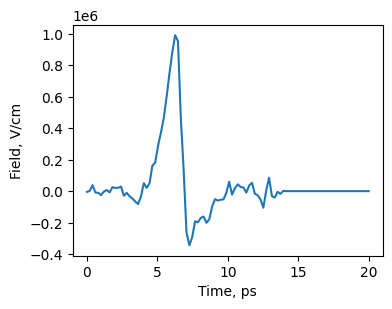

In [9]:
# field, in V/cm, as a function of time, in picoseconds
field = lambda time: thz_field(time, peak_field=100e4)
time = np.linspace(0, 20, 100)
plt.figure(figsize=(4, 3))
plt.plot(time, np.array([field(t) for t in time]))
plt.xlabel("Time, ps")
plt.ylabel("Field, V/cm")
plt.show()

### Define two subsequent, time-delayed, and skew-polarized THz pulses
The aforementioned field is used to define a combined pulse which consists of two time-delayed, skew-polarized pulses: \
The first THz pulse is polarized along the Z-axis, the second pulse follows with a time-delay of 10 ps and is polarized in Z-Y-direction. \
We thus expect for the Z-component of the dipole moment expectation value to oscillate with opposite phases for the two different enantiomers of propylene oxide.

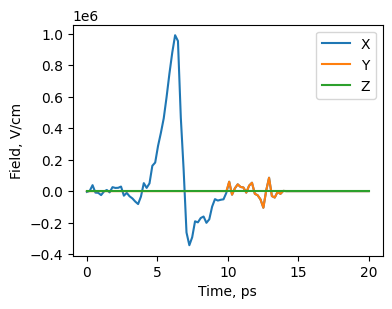

In [32]:
def pulses(t, delta_t, theta, phi):      #theta, phi in degrees, peak_field in V/m
            if t < delta_t:
                return 0
            else:
                theta = np.deg2rad(theta)
                phi = np.deg2rad(phi)
                return field(t) * np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])

all_fields = lambda t: pulses(t,0, 90, 0) + pulses(t, 10, 90, 90)

time = np.linspace(0, 20, 100)
plt.figure(figsize=(4, 3))
plt.plot(time, np.array([all_fields(t) for t in time]), label=["X", "Y", "Z"])
plt.xlabel("Time, ps")
plt.ylabel("Field, V/cm")
plt.legend()
plt.show()

### Propagate

Solve time-dependent Schrödinger equation with THz field. Molecule initially in the ground rotational state. A time evolution operator is defined to iteratively calculate the coefs for every time step. The coefficients are also stored for each tenth time step.


In [34]:
# convert field-free Hamiltonian from MHz to 1/ps
h0_matrix_invps = h0_matrix * 1e-6

# convert dipole matrix elelements to units cm/(V*ps)
# to make sure that when it is multiplied with field in V/cm, the final units will be 1/ps
dipole_matrix_invps_l = dipole_matrix * DEBYE_TIMES_VOLTS_PER_CM_INTO_INVPS
# add converted dipole matrix elements for other enantiomer
dipole_matrix_invps_ch = dipole_matrix_ch * DEBYE_TIMES_VOLTS_PER_CM_INTO_INVPS


def propagate_coefs(dipole_matrix_invps):
    # initial population - ground state only
    coefs = np.zeros(len(h0_matrix_invps))
    coefs[0]= 1.0
    coefs_time = propagate(
        start_time=0.0,
        end_time=200,
        time_step=0.1,
        field=all_fields,
        field_free_matrix=h0_matrix_invps,
        dipole_matrix=dipole_matrix_invps,
        initial_coefs=coefs,
        on_update=lambda i, t, c: (  # print population of state no. 0 at each 100th timestep
            print(
                t.round(2),
                np.abs(c[0]) ** 2,
            )
            if i % 100 == 0
            else None
        ),
    )
    return coefs, coefs_time


# calculate time propagation of coefficients for both enantiomers
coefs, coefs_time = propagate_coefs(dipole_matrix_invps_l)
coefs_ch, coefs_time_ch = propagate_coefs(dipole_matrix_invps_ch)


# keep only every 10th element (resulting time-resolution 0.1 ps)
coefs_time = coefs_time[0::10]
coefs_time_ch = coefs_time_ch[0::10]

0.0 0.9999967150801913
10.01 0.05520233251809911
20.01 0.05264306640074982
30.02 0.05264306640074982
40.02 0.05264306640074982
50.03 0.05264306640074982
60.03 0.05264306640074982
70.04 0.05264306640074982
80.04 0.05264306640074982
90.05 0.05264306640074982
100.05 0.05264306640074982
110.06 0.05264306640074982
120.06 0.05264306640074982
130.07 0.05264306640074982
140.07 0.05264306640074982
150.08 0.05264306640074982
160.08 0.05264306640074982
170.09 0.05264306640074982
180.09 0.05264306640074982
190.1 0.05264306640074982
0.0 0.9999967150801913
10.01 0.05520233251809884
20.01 0.052643066400749616
30.02 0.052643066400749616
40.02 0.052643066400749616
50.03 0.052643066400749616
60.03 0.052643066400749616
70.04 0.052643066400749616
80.04 0.052643066400749616
90.05 0.052643066400749616
100.05 0.052643066400749616
110.06 0.052643066400749616
120.06 0.052643066400749616
130.07 0.052643066400749616
140.07 0.052643066400749616
150.08 0.052643066400749616
160.08 0.052643066400749616
170.09 0.0526

### Plot populations of states

Plot time-evolution of populations for different rotational states

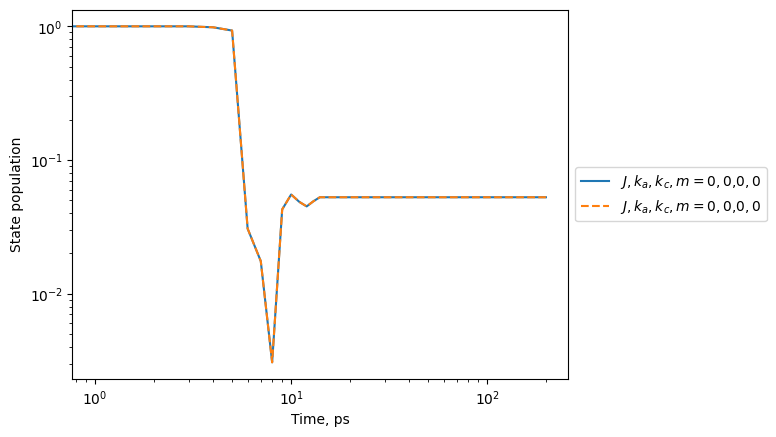

In [35]:
plot_thresh = 1e-1

# extract time grid
time_list = np.array([time for (ind, time, coef) in coefs_time])
time_list_ch = np.array([time for (ind, time, coef) in coefs_time_ch])

# extract populations
populations_time = np.array([np.abs(coef) ** 2 for (ind, time, coef) in coefs_time])
populations_time_ch = np.array([np.abs(coef) ** 2 for (ind, time, coef) in coefs_time_ch])

# plot significant populations
for state_ind, population in enumerate(populations_time.T):
    if np.max(population) > plot_thresh:
        label = "$J,k_a,k_c,m=$" + ",".join(
            f"{elem}$" for elem in assignment[state_ind]
        )
        plt.plot(time_list, population, label=label)
for state_ind, population in enumerate(populations_time_ch.T):
    if np.max(population) > plot_thresh:
        label = "$J,k_a,k_c,m=$" + ",".join(
            f"{elem}$" for elem in assignment[state_ind]
        )
        plt.plot(time_list, population, label=label, linestyle = "dashed")
plt.xlabel("Time, ps")
plt.ylabel("State population")
plt.yscale("log")
plt.xscale("log")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

As is evident in the figure above, there exists no visible difference in state populations of both enantiomers of propylene oxide, even if the axes are blown up with log scale.

### Plot expectation value of the dipole moment

Maximum deviation of dipole moment expectation value of both enantiomers:0.015350311530409583


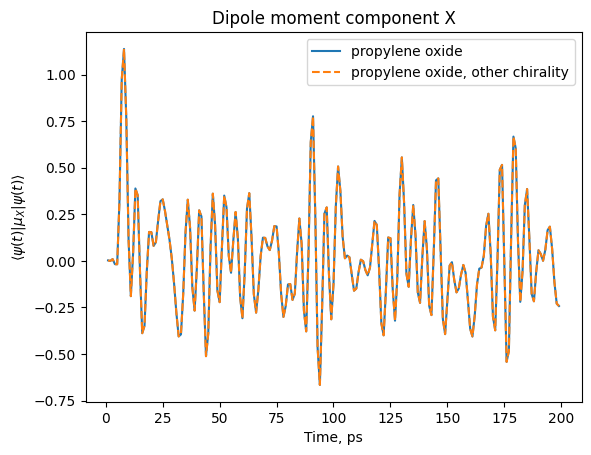

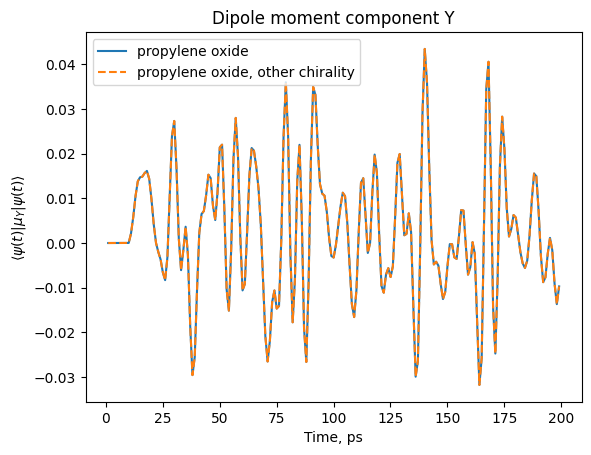

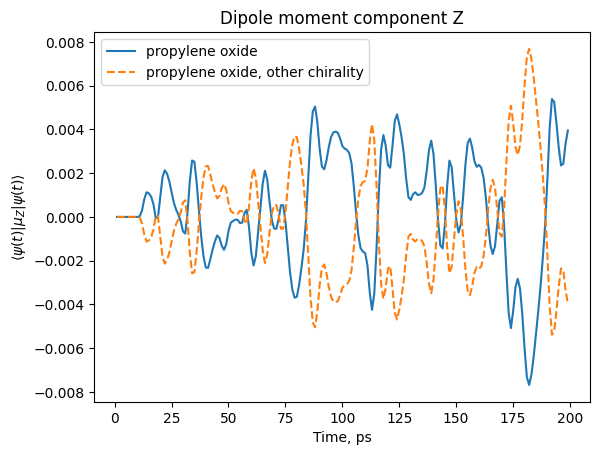

In [36]:
# set time limits to 'zoom in'
time_min = 0
time_max = 200

# extract time grid
time_list = np.array(
    [time for (ind, time, coef) in coefs_time if time > time_min and time < time_max]
)
time_list_ch = np.array(
    [time for (ind, time, coef) in coefs_time_ch if time > time_min and time < time_max]
)
# extract coefficients for the propylene oxide
c_time = np.array(
    [coef for (ind, time, coef) in coefs_time if time > time_min and time < time_max]
)
c_time_ch = np.array(
    [coef for (ind, time, coef) in coefs_time_ch if time > time_min and time < time_max]
)

# compute expectation values of dipole moment for propylene oxide
dipole_expval = np.einsum(
    "ti,aij,tj->ta", np.conj(c_time), dipole_matrix, c_time, optimize='optimal'
)
dipole_expval_ch = np.einsum(
    "ti,aij,tj->ta", np.conj(c_time_ch), dipole_matrix_ch, c_time_ch, optimize='optimal'
)

print(f"Maximum deviation of dipole moment expectation value of both enantiomers:{np.max(np.abs(dipole_expval-dipole_expval_ch))}")


# plot expectation values for X, Y, and Z projections of dipole moment
for icart, cart in enumerate(('X', 'Y', 'Z')):
    plt.plot(time_list, np.real(dipole_expval[:, icart]), label='propylene oxide')
    plt.plot(time_list_ch, np.real(dipole_expval_ch[:, icart]), label='propylene oxide, other chirality', linestyle = "dashed")
    plt.title(f"Dipole moment component {cart}")
    plt.xlabel("Time, ps")
    plt.ylabel(f"$\\langle \\psi(t)|\\mu_{cart}| \\psi(t)\\rangle$")
    plt.legend()
    plt.show()

In stark contrast to the state populations, and to the other spatial components of the dipole moment, the Z-components of the both enantiomers oscillate with opposite phases, which is in agreement with the theoretical prediction.

### Evaluate degree of orientation

The degree of orientation is defined by the expectation value of the $\cos\beta$ function:

$$
\langle\psi(t) |\cos\theta|\psi(t)\rangle,
$$

where $\theta$ is the angle between the dipole moment vector in the molecular frame and the field polarisation axis in the laboratory frame, and $\psi(t)$ is the rotational wavepacket.
Note, the rotational wavepacket is also a function of three Euler angles: $\alpha$, $\beta$, and $\gamma$.
For shortness, these variables are skipped in our notation.

To compute the expectation value, we can employ a Monte Carlo method. This approach involves approximating the integral that represents the expectation value as a sum over a discrete set of points that are sampled based on the density. Specifically, the expectation value can be approximated as follows:

$$
\langle\psi(t) |\cos\theta|\psi(t)\rangle = \int \psi^*(t)\psi(t) \cos\theta d\alpha d\beta\sin\beta d\gamma =  \int \rho(t) \cos\theta d\alpha d\beta d\gamma
\approx \sum_{\{\alpha_g,\beta_g,\gamma_g\} \sim \rho(t)}^{N_g} \cos\theta(\alpha_g,\beta_g,\gamma_g),
$$

where $\rho(t) = \psi^*(t)\psi(t)\sin\beta$ is introduced as the rotational density function.

Extending this approach, we can map the discretely sampled Euler angles $\{\alpha_g,\beta_g,\gamma_g\}_g^{N_g}$,
which are distributed according to the rotational density $\rho(t)$, to the elements of the direction-cosine
rotation matrix $R{(3\times 3)}$ that rotates a vector from the molecular to the laboratory frame.
Each set of Euler angles generates a corresponding rotation matrix $R_g = R(\alpha_g,\beta_g,\gamma_g)$.
This allows us to evaluate how distributions in the molecular frame transform to the laboratory frame,
and compute any related matrix elements.

For instance, to calculate the matrix element of $\cos\theta$ for OCS, with the dipole moment vector aligned along the molecular $z$ axis and the external field polarisation aligned along the laboratory $Z$ axis, we use the following approximation:

$$
\langle\psi(t) |\cos\theta|\psi(t)\rangle \approx \sum_{\{\alpha_g,\beta_g,\gamma_g\} \sim \rho(t)}^{N_g} \cos\theta(\alpha_g,\beta_g,\gamma_g)
= \sum_{\{\alpha_g,\beta_g,\gamma_g\} \sim \rho(t)}^{N_g} [R_g\cdot (0, 0, 1)]_Z,
$$

where $[..]_Z$ means that we take only the third component of the resulting dot product, corresponding to the $Z$ projection.

In practice, the process begins by understanding the composition of the rotational wavepacket, which is expressed
as a linear combination of rotational wavefunctions:

$$
\psi(t) = \sum_{J,k_a,k_c,m} c_{J,k_a,k_c,m}(t) \phi_{J,k_a,k_c,m},
$$

with time-dependent coefficients $c(t)$ obtained from the solution of the TDSE, for example, using `tdse.propagate`.

Rotational wavefunctions are in turn eigenfunctions of the field-free rotational Hamiltonian.
They are expressed as linear combinations of symmetric-top functions:

$$
\phi_{J,k_a,k_c,m} = \sum_{k_a,k_c} c_{k_a,k_c}^{(J,m)}|J,k_a,k_c,m\rangle.
$$

The functions $\phi_{J,k_a,k_c,m}$ depend on the three Euler angles $\alpha$, $\beta$, and $\gamma$.
The eigenfunction coefficients $c_{k_a,k_c}^{(J,m)}$ together with the values of rotational wavefunctions $\phi_{J,k_a,k_c,m}$ on a grid of Euler angle values are calculated by `field_free.field_free` or `field_free.field_free_linear` functions, as we did it in the cells above.

In [ ]:
# grid of Euler angles, as output by `field_free_linear`
alpha, beta, gamma = grid
no_grid_points = len(alpha) * len(beta) * len(gamma)  # total number of grid points
print("total number of points in Euler grid:", no_grid_points)

# arrange field-free rotational wavefunctions on grid in the same order of functions (quantum numbers)
# as used for the field-free and dipole matrix elements
func_on_grid = np.concatenate(
    [rot_func_on_grid[j].reshape(-1, no_grid_points) for j in range(max_j + 1)], axis=0
)

total number of points in Euler grid: 27000


After obtaining the rotational wavefunctions $\phi_{J,k_a,k_c,m}$ evaluated on a grid on Euler angles and stored in the array `func_on_grid`, the next step is to calculate the values of the time-dependent wavepacket $\psi(t)$ on the same grid.
The wavepacket is represented by $\psi(t) = \sum_{J,k_a,k_c,m} c_{J,k_a,k_c,m}(t) \phi_{J,k_a,k_c,m}$, where $c_{J,k_a,k_c,m}(t)$ are the time-dependent coefficients that have been computed previously using the `tdse.propagate` function. These coefficients are stored in a collection named `coefs_time`.
To evaluate $\psi(t)$ on the grid, we essentially need to perform the dot product between the coefficients and the wavefunctions, evaluated at each point on the grid and each time point $t$.


In [ ]:
# extract wavepacket coefficients
coefs = np.array([coef for (ind, time, coef) in coefs_time])

# compute wavepacket on grid of Euler angles
wavepack_on_grid = np.dot(func_on_grid.T, coefs.T)

print(wavepack_on_grid.shape) # shape = (no_grid_points, no_time_steps)

(27000, 2000)


Now, evaluate the time-dependent rotational density function $\rho(t) = \psi^*(t)\psi(t)\sin\beta$ and store it in `dens_on_grid`

In [ ]:

dens_on_grid = wavepack_on_grid * np.conj(wavepack_on_grid)
dens_on_grid = dens_on_grid.real

# reshape density from a 3D direct product grid to the three 1D nested grids
dens_on_grid = dens_on_grid.reshape(len(alpha), len(beta), len(gamma), -1)

# multiply by spherical volume element \sin\beta
sin_beta = np.sin(beta)
dens_on_grid *= sin_beta[None, :, None, None]

print(dens_on_grid.shape) # shape = (len(alpha), len(beta), len(gamma), no_time_steps)

(30, 30, 30, 2000)


#### Monte-Carlo procedure

Generate dicrete samples of Euler angles according to the rotational density, in `dens_on_grid`, and map them into the elements of the direction-cosine rotation matrix.

In [ ]:
dens_interpolate = RegularGridInterpolator((alpha, beta, gamma), dens_on_grid)
max_dens = np.max(dens_on_grid, axis=(0, 1, 2))

# generate uniformly-distributed samples of Euler angles
npoints_sample = 100000
euler_sample_points = np.random.uniform(
    low=[0, 0, 0], high=[2 * np.pi, np.pi, 2 * np.pi], size=(npoints_sample, 3)
)

# evaluate density on the samples and apply rejection sampling
dens = dens_interpolate(euler_sample_points) / max_dens
eta = np.random.uniform(0.0, 1.0, size=len(dens))
euler_sample_points = [euler_sample_points[np.where(d > eta)] for d in dens.T]

# note, different elements in the list `euler_sample_points` correspond to different time steps

# map samples of Euler angles to samples of direction-cosine rotation matrix
rotation_matrix = [
    Rotation.from_euler("zyz", points).as_matrix() for points in euler_sample_points
]

# note, different elements in the list `rotation_matrix` correspond to different time steps

# inspect shape, for example, for time_step=0
time_step = 0
print(rotation_matrix[time_step].shape) # shape = (no_sample_points, 3, 3)

(63739, 3, 3)


And finally, evaluate expectation values of desired functions of Euler angles, e.g., $\cos\theta$.

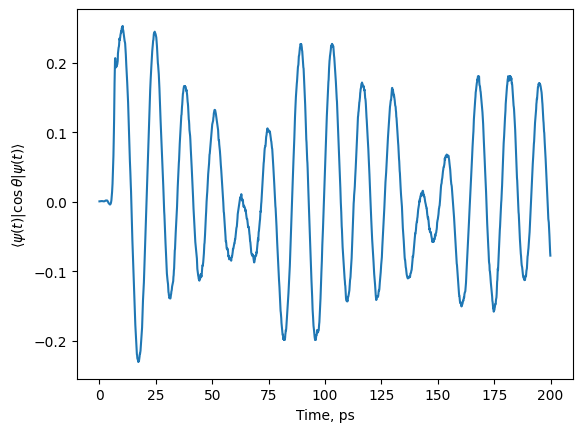

In [ ]:
mol_vector = [0, 0, 1]
lab_vector = [np.dot(rot, mol_vector) for rot in rotation_matrix]

cos_theta = np.array([np.mean(vec[:, 2]) for vec in lab_vector])

plt.plot(time_list, cos_theta)
plt.xlabel('Time, ps')
plt.ylabel('$\\langle \\psi(t)|\\cos\\theta|\\psi(t)\\rangle$')
plt.show()

### Analytic evaluation of the degree of orientation

The matrix elements of some of functions of Euler angles can be evaluated analytically, similarly to the dipole moment matrix elements.

Here, we use analytic implementation of the $\langle \phi_{J',k_a',k_c',m'} |\cos\beta| \phi_{J,k_a,k_c,m}\rangle$ matrix elements, implemented in `stark.costheta_me_matrix`,
and compare it with the resutls of Monte-Carlo simulations.

In [ ]:
from stark import costheta_me_matrix

# matrix elements <cos(beta)> in rotational field-free basis
costheta_matrix = costheta_me_matrix(max_j, rot_vec, linear=False)

# extract wavepacket coefficients
coefs = np.array([coef for (ind, time, coef) in coefs_time])  # (time, bas)

# transform matrix <cos(beta)> to wavepacket representation
costheta_time = np.einsum(
    "ti,kij,tj->t", np.conj(coefs), costheta_matrix, coefs, optimize="optimal"
)

# check if values are real
print("maximal imaginary component in <cos(beta)> (expected small):", np.max(np.abs(costheta_time.imag)))
costheta_time = costheta_time.real

maximal imaginary component in <cos(beta)> (expected small): 4.6891743959998067e-17


Plot results and compare with Monte-Carlo values.

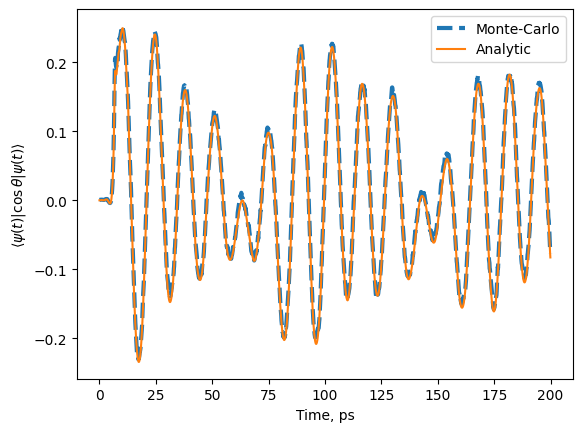

In [ ]:
plt.plot(time_list, cos_theta, label="Monte-Carlo", linestyle='--', linewidth=3)
plt.plot(time_list, costheta_time, label="Analytic")
plt.xlabel('Time, ps')
plt.ylabel('$\\langle \\psi(t)|\\cos\\theta|\\psi(t)\\rangle$')
plt.legend()
plt.show()